# Explaining feature importance with Permutation-based Variable Importance (PVI) - Hear Disease Prediction

## Report


### Dataset
The dataset used is Heart Disease prediction dataset from Kaggle (https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset). In this dataset, target = 0 indicated no disease and target = 1 indicates disease.
The features are:
| Value in human-readable format                              | Feature name in dataset |
|-------------------------------------------------------------|-------------------------|
|                                                         Age |                     age |
|                                      Sex (1=male, 0=female) |                     sex |
| chest pain type (4 values)                                  | cp                      |
| Resting blood pressure (mmHg)                               | trestbps                |
| Serum cholestorol in mg/dl                                  | chol                    |
| Is fasting blood sugar > 120 mg/dl                          | fbs                     |
| Resting electrocardiographic results (3 values)             | restecg                 |
| Maximum heart rate achieved                                 | thalach                 |
| Exercise induced angina (1=yes, 0=no)                       | exang                   |
| ST depression induced by exercise relative to rest          | oldpeak                 |
| The slope of the peak exercise ST segment                   | slope                   |
| Number of major vessels (0-3) colored by flourosopy         | caa                     |
| Thalassemia (0=normal, 1=fixed defect, 2=reversable defect) | thall                   |

### 0. Model training
First a model (Random Forest) was trained on the preprocessed dataset. Its metrics were as follows:

|               |   recall | precision |       f1 | accuracy |      auc |
|--------------:|---------:|----------:|---------:|---------:|---------:|
| Random Forest | 0.77 |  0.77 | 0.77 |  0.81 | 0.94 |

### 1. PVI computation
Secondly, PVI for the Random Forest was computed. The following plot shows the six most important features:

![alt text](images/1.png "PVI for Random Forest")

According to PVI, by far the most important feature was the result of fluoroscopy

### 2. PVI for different models

#### Random Forest (max depth = 2)

![alt text](images/2.png "PVI for Random Forest (shallow)")

In a shallow Random Forest, the importance ranking is the same in places 1-3, however later that changes. The differences between consecutive importance values are not as drastic as in a deeper forest. It is important to note that `thall_2` and `thall_3` are two categories of the same variable. That shows an issue with our feature importance measures - models need some variable encodings that do not necessarily make sens for humans (who would like to lump all `thall_1`, `2`, `3` together).

#### Logistic Regression

![alt text](images/3.png "PVI for Random Forest (shallow)")

Once again, the drops of importance value between consecutive variables in the ranking become noticeable.

#### K Nearest Neighbors

![alt text](images/4.png "PVI for Random Forest (shallow)")

KNN model analysis shows a different picture than the predecessing ones. Some variables (`caa`, `slp`) disappear from the ranking of the most significant features, other appear in it (`exng`, `sex`). 

### 3. PVI comparison with Gini importance and TreeSHAP for Random Forest

#### A) Gini importance (`.feature_importances_`)

![alt text](images/5.png "Gini importance")

#### B) TreeSHAP

![alt text](images/6.png "TreeSHAP")

To analyse the global SHAP influence of variables, mean of absolute values of SHAP contributions for all variables was computed. Feature importance in terms of Gini importance seems to be quite similar across variables.

### 6. Final Remarks
All the plots above are commented. Appendix contains the code used to produce the results.

## Appendix

### Install dependencies

In [1]:
!pip install -U pip 'dalex==1.5.0' \
    'shap==0.41.0' 'nbformat>=4.2.0' 'scikit-learn==1.0.2' \
    'pandas==1.3.5' 'numpy==1.22.4' 'lime==0.2.0.1' \
    'alibi==0.8.0' gdown seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### Download data

In [2]:
import gdown
gdown.download(id='1yBNUVzUAwb5LeQ9eGD55YVPGq-5HoX4c', output='heart.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1yBNUVzUAwb5LeQ9eGD55YVPGq-5HoX4c
To: /home/maciej/Documents/Studia/Zima 2022/XAI/MyRepo/eXplainableMachineLearning-2023/Homeworks/HW5/MaciejPióro/heart.csv
100%|██████████| 11.3k/11.3k [00:00<00:00, 17.6MB/s]


'heart.csv'

### Load & Preprocess data
First the data is loaded and some test set size is selected. To make the analysis reproducible, the seed is set.


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dalex as dx
import random
import numpy as np
from sklearn.utils import shuffle

SEED = 997
TEST_SIZE = 0.1

data = shuffle(pd.read_csv('heart.csv'), random_state=SEED)

Dataset contains two categorical variable: `cp` and `restecg`. Those are one-hot encoded in preprocessing. Generally models can benefit from one-hot encoding the categorical variables. What's more, we translate and scale the input features to follow the N(0, 1) normal distribution. The data is also split into test and train sets.

In [33]:
from typing import Tuple, Optional
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def to_one_hot(data, column):
    dummies = pd.get_dummies(data[column])
    for dummy_value in dummies.columns:
        data = pd.concat([data, dummies[dummy_value].rename(f'{column}_{dummy_value}')], axis=1)
    return data.drop(column, axis=1)

def scale_dataframe(df: pd.DataFrame, scaler: Optional[StandardScaler] = None) -> Tuple[pd.DataFrame, StandardScaler]:
    res_df = df.copy()
    if scaler is None:
        scaler = StandardScaler()
        scaler = scaler.fit(res_df[res_df.columns])
    res_df[res_df.columns] = scaler.transform(res_df[res_df.columns])
    return res_df, scaler

data = to_one_hot(data, 'cp')
data = to_one_hot(data, 'restecg')
data = to_one_hot(data, 'thall')

train, test = train_test_split(data, test_size=TEST_SIZE, random_state=SEED)

X_train, train_scaler = scale_dataframe(train.drop(columns=['output']))
y_train = train['output']

X_test, _ = scale_dataframe(test.drop(columns=['output']), train_scaler)
y_test = test['output']

### Train a model
The basic model that we use is Random Forest Classifier

In [34]:
import dalex as dx
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=SEED)

model.fit(X_train, y_train)

tree_model = model

### 1. Calculate PVI for the model

In [35]:
def pf(model, df):
    return model.predict_proba(df)[:, 1]

explainer = dx.Explainer(model, X_test, y_test, predict_function=pf, label='Random Forest')
explainer.model_performance()

Preparation of a new explainer is initiated

  -> data              : 31 rows 21 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 31 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest
  -> predict function  : <function pf at 0x7ff67959dca0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.02, mean = 0.448, max = 0.97
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.72, mean = -0.0284, max = 0.81
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


,recall,precision,f1,accuracy,auc
Random Forest,0.769231,0.769231,0.769231,0.806452,0.940171


In [36]:
pvi = explainer.model_parts(random_state=SEED)
pvi.plot(
    max_vars=6, 
    title=None, 
    show=False
)

### 2. Train further models

#### Shallow Random Forest Classifier

In [37]:
def pf(model, df):
    return model.predict_proba(df)[:, 1]

model = RandomForestClassifier(random_state=SEED, max_depth=2)

model.fit(X_train, y_train)

explainer = dx.Explainer(model, X_test, y_test, predict_function=pf, label='Random Forest (shallow)')
pvi = explainer.model_parts(random_state=SEED)
pvi.plot(
    max_vars=6, 
    title=None, 
    show=True
)

Preparation of a new explainer is initiated

  -> data              : 31 rows 21 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 31 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest (shallow)
  -> predict function  : <function pf at 0x7ff67963b790> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.147, mean = 0.47, max = 0.846
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.706, mean = -0.051, max = 0.666
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


#### Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression

def pf(model, df):
    return model.predict_proba(df)[:, 1]

model = LogisticRegression(random_state=SEED)

model.fit(X_train, y_train)

explainer = dx.Explainer(model, X_test, y_test, predict_function=pf, label='Logistic Regression')
pvi = explainer.model_parts(random_state=SEED)
pvi.plot(
    max_vars=6, 
    title=None, 
    show=True
)

Preparation of a new explainer is initiated

  -> data              : 31 rows 21 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 31 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Logistic Regression
  -> predict function  : <function pf at 0x7ff6795b1040> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00153, mean = 0.452, max = 0.994
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.89, mean = -0.0329, max = 0.928
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but LogisticRegression was fitted with feature names


#### KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier

def pf(model, df):
    return model.predict_proba(df)[:, 1]

model = KNeighborsClassifier(n_neighbors=5)

model.fit(X_train, y_train)

explainer = dx.Explainer(model, X_test, y_test, predict_function=pf, label='KNN')
pvi = explainer.model_parts(random_state=SEED)
pvi.plot(
    max_vars=6, 
    title=None,
    show=True
)

Preparation of a new explainer is initiated

  -> data              : 31 rows 21 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 31 values
  -> model_class       : sklearn.neighbors._classification.KNeighborsClassifier (default)
  -> label             : KNN
  -> predict function  : <function pf at 0x7ff67959d3a0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.432, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.6, mean = -0.0129, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


### 3. PVI comparison with other feature importance metrics

#### `.feature_importances_` from sklearn

[Text(0.5, 1.0, 'Feature importance (sklearn .feature_importances_)')]

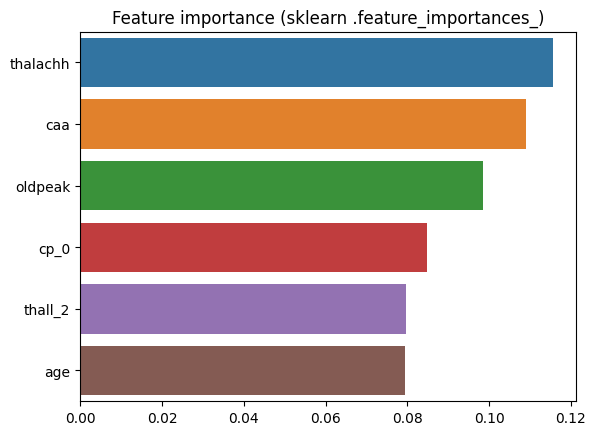

In [40]:
def topk_index(array: np.array, k: int):
    return (-tree_model.feature_importances_).argsort()[:6]

idx = topk_index(tree_model.feature_importances_, 6)
sns.barplot(
    x=tree_model.feature_importances_[idx],
    y=tree_model.feature_names_in_[idx]
).set(title='Feature importance (sklearn .feature_importances_)')

#### TreeSHAP

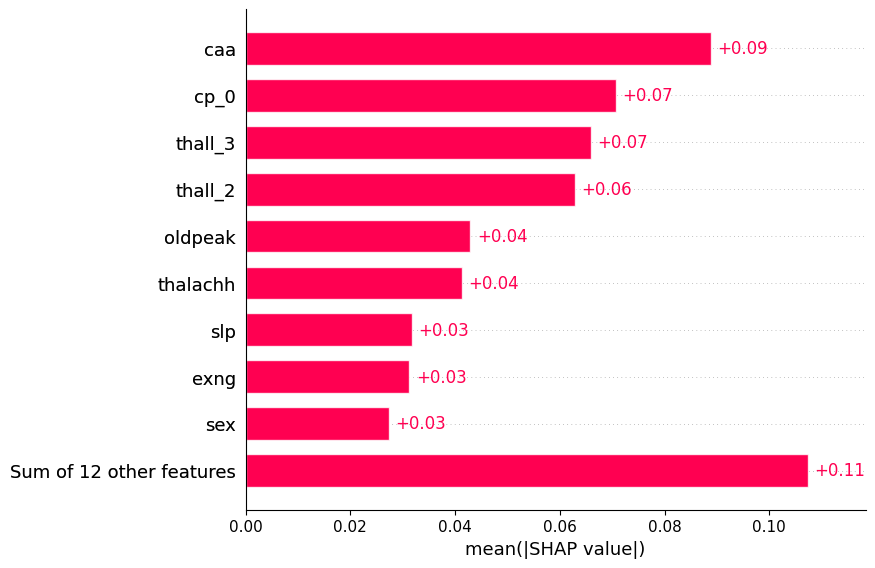

In [41]:
import shap
shap_explainer = shap.explainers.Tree(tree_model, data=X_train, model_output='probability', random_state=SEED)
shap_values = shap_explainer(X_test)
shap.plots.bar(shap_values.abs.mean(0)[:, 1])